In [2]:
# import neccessary packages and libraries
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Data Overview

The well known questions and answers website Stack Overflow has been conducted annual surveys for a decade now.  These are the largest and the most comprehensive surveys of coders ever conducted. The anonymized results of the surveys are publicly available for analysis at [Stack Overflow Anual Developer Survey](https://insights.stackoverflow.com/survey).

The 2020 Stack Overflow Survey was conducted in February 2020, just before the COVID-19 pandemic affected the entire world. There are 60 questions distributed over six sections:

1. Basic Information
2. Education, Work, Career
3. Technology and Tech Culture
4. Stack Overflow Usage + Community
5. Demographic Information
6. Survey Opinion and Final Questions

The survey had 64461 (almost 65k) responses from 184 countries and regions.

## Upload Data

There are two csv files, the `results_public` file contains the survey results and the `results_schema` file contains the list of columns in the first file, together with heir associated questions. 

In [3]:
# create a path string
mypath = os.getcwd()

#upload datafiles as pandas dataframes

#df17 = pd.read_csv(path+'/data/survey17_results_public.csv', low_memory=False)
#df18 = pd.read_csv(path+'/data/survey18_results_public.csv', low_memory=False)
#df19 = pd.read_csv(path+'/data/survey19_results_public.csv', low_memory=False)
df = pd.read_csv(mypath+'/data/survey20_results_public.csv', low_memory=False)

#df17s = pd.read_csv(path+'/data/survey17_results_schema.csv', low_memory=False)
#df18s = pd.read_csv(path+'/data/survey18_results_schema.csv', low_memory=False)
#df19s = pd.read_csv(path+'/data/survey19_results_schema.csv', low_memory=False)
dfs = pd.read_csv(mypath+'/data/survey20_results_schema.csv', low_memory=False)

In [4]:
# the survey file
df.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8


In [5]:
# the description file
dfs.head()

,Column,QuestionText
0,Respondent,Randomized respondent ID number (not in order ...
1,MainBranch,Which of the following options best describes ...
2,Hobbyist,Do you code as a hobby?
3,Age,What is your age (in years)? If you prefer not...
4,Age1stCode,At what age did you write your first line of c...


## General Data Information

In [5]:
# get the shape of the data
df.shape

(64461, 61)

In [8]:
# save the column names as a list
cols = list(dfs.Column.unique())
cols

['Respondent',
 'MainBranch',
 'Hobbyist',
 'Age',
 'Age1stCode',
 'CompFreq',
 'CompTotal',
 'ConvertedComp',
 'Country',
 'CurrencyDesc',
 'CurrencySymbol',
 'DatabaseDesireNextYear',
 'DatabaseWorkedWith',
 'DevType',
 'EdLevel',
 'Employment',
 'Ethnicity',
 'Gender',
 'JobFactors',
 'JobSat',
 'JobSeek',
 'LanguageDesireNextYear',
 'LanguageWorkedWith',
 'MiscTechDesireNextYear',
 'MiscTechWorkedWith',
 'NEWCollabToolsDesireNextYear',
 'NEWCollabToolsWorkedWith',
 'NEWDevOps',
 'NEWDevOpsImpt',
 'NEWEdImpt',
 'NEWJobHunt',
 'NEWJobHuntResearch',
 'NEWLearn',
 'NEWOffTopic',
 'NEWOnboardGood',
 'NEWOtherComms',
 'NEWOvertime',
 'NEWPurchaseResearch',
 'NEWPurpleLink',
 'NEWSOSites',
 'NEWStuck',
 'OpSys',
 'OrgSize',
 'PlatformDesireNextYear',
 'PlatformWorkedWith',
 'PurchaseWhat',
 'Sexuality',
 'SOAccount',
 'SOComm',
 'SOPartFreq',
 'SOVisitFreq',
 'SurveyEase',
 'SurveyLength',
 'Trans',
 'UndergradMajor',
 'WebframeDesireNextYear',
 'WebframeWorkedWith',
 'WelcomeChange',
 'W

In [9]:
# get the number of NaN values in each column
df_null = df.isnull().sum()
df_null

Respondent                0
MainBranch              299
Hobbyist                 45
Age                   19015
Age1stCode             6561
                      ...  
WebframeWorkedWith    22182
WelcomeChange         11778
WorkWeekHrs           23310
YearsCode              6777
YearsCodePro          18112
Length: 61, dtype: int64

In [10]:
# the columns with no missing data
no_null = set(df.columns[np.sum(df.isnull()) == 0]) 
no_null

{'Respondent'}

In [11]:
# columns with more than 75% values missing
most_missing_cols = df.columns[df.isnull().mean() > 0.75]
most_missing_cols

Index([], dtype='object')

In [12]:
# most missing values, in descending order, written as percentages
df.isnull().mean().sort_values(ascending=False).round(3)

ConvertedComp             0.461
CompTotal                 0.460
NEWPurchaseResearch       0.421
PurchaseWhat              0.389
WebframeDesireNextYear    0.379
                          ...  
Employment                0.009
Country                   0.006
MainBranch                0.005
Hobbyist                  0.001
Respondent                0.000
Length: 61, dtype: float64

In [14]:
# columns with more than 30% values missing
most_missing_vals = df.columns[df.isnull().mean() > 0.30]
most_missing_vals

Index(['CompFreq', 'CompTotal', 'ConvertedComp', 'DatabaseDesireNextYear',
       'MiscTechDesireNextYear', 'MiscTechWorkedWith', 'NEWDevOps',
       'NEWDevOpsImpt', 'NEWJobHunt', 'NEWJobHuntResearch', 'NEWOnboardGood',
       'NEWOvertime', 'NEWPurchaseResearch', 'OrgSize', 'PurchaseWhat',
       'Sexuality', 'WebframeDesireNextYear', 'WebframeWorkedWith',
       'WorkWeekHrs'],
      dtype='object')

In [51]:
# general data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64461 entries, 0 to 64460
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Respondent                    64461 non-null  int64  
 1   MainBranch                    64162 non-null  object 
 2   Hobbyist                      64416 non-null  object 
 3   Age                           45446 non-null  float64
 4   Age1stCode                    57900 non-null  object 
 5   CompFreq                      40069 non-null  object 
 6   CompTotal                     34826 non-null  float64
 7   ConvertedComp                 34756 non-null  float64
 8   Country                       64072 non-null  object 
 9   CurrencyDesc                  45472 non-null  object 
 10  CurrencySymbol                45472 non-null  object 
 11  DatabaseDesireNextYear        44070 non-null  object 
 12  DatabaseWorkedWith            49537 non-null  object 
 13  D

In [52]:
# look at the numerical data
df.describe()

,Respondent,Age,CompTotal,ConvertedComp,WorkWeekHrs
count,64461.000000,45446.000000,3.482600e+04,3.475600e+04,41151.000000
mean,32554.079738,30.834111,3.190464e+242,1.037561e+05,40.782174
std,18967.442360,9.585392,inf,2.268853e+05,17.816383
min,1.000000,1.000000,0.000000e+00,0.000000e+00,1.000000
25%,16116.000000,24.000000,2.000000e+04,2.464800e+04,40.000000
50%,32231.000000,29.000000,6.300000e+04,5.404900e+04,40.000000
75%,49142.000000,35.000000,1.250000e+05,9.500000e+04,44.000000
max,65639.000000,279.000000,1.111111e+247,2.000000e+06,475.000000


## Specific Information from Data

In [15]:
# the number of countries involved
len(df.Country.unique())

184

In [16]:
# distribution of respondends on countries
country_counts = df.Country.value_counts()
country_counts

United States     12469
India              8403
United Kingdom     3896
Germany            3890
Canada             2191
                  ...  
North Korea           1
Gabon                 1
Kiribati              1
Mali                  1
Saint Lucia           1
Name: Country, Length: 183, dtype: int64

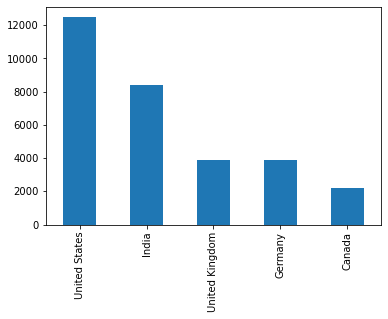

In [17]:
# countries with more than 1000 respondents
most_represented_countries = country_counts[country_counts > 2000]
most_represented_countries.plot(kind='bar');

In [18]:
# countries with less than 100 respondents
least_represented_countries = country_counts[country_counts < 100]
len(least_represented_countries)

114

In [20]:
# distribution by gender 
df.Gender.value_counts()

Man                                                            46013
Woman                                                           3844
Non-binary, genderqueer, or gender non-conforming                385
Man;Non-binary, genderqueer, or gender non-conforming            121
Woman;Non-binary, genderqueer, or gender non-conforming           92
Woman;Man                                                         76
Woman;Man;Non-binary, genderqueer, or gender non-conforming       26
Name: Gender, dtype: int64

In [23]:
# distribution by gender in percentages
df.Gender.value_counts()/df.shape[0]

Man                                                            0.713811
Woman                                                          0.059633
Non-binary, genderqueer, or gender non-conforming              0.005973
Man;Non-binary, genderqueer, or gender non-conforming          0.001877
Woman;Non-binary, genderqueer, or gender non-conforming        0.001427
Woman;Man                                                      0.001179
Woman;Man;Non-binary, genderqueer, or gender non-conforming    0.000403
Name: Gender, dtype: float64

In [25]:
# what percentage of Gender entries are missing
df.Gender.isnull().sum()/df.shape[0]

0.21569631249903043

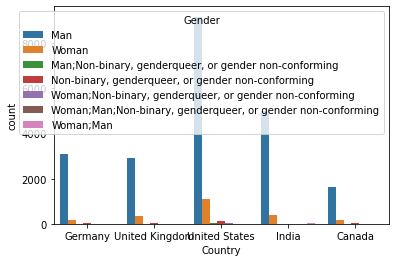

In [32]:
# distribution by gender and country with most respondents
df_most_repres_countries = df[df['Country'].map(df['Country'].value_counts()) > 2000]

# adapted clustered bar chart of Country and gender
sns.countplot(data=df_most_repres_countries, x='Country', hue='Gender');

In [96]:
# percentage of most represented countries respondents
df_most_repres_countries.shape[0]/df.shape[0]

0.4785684367291851

In [52]:
pd.set_option('display.max_colwidth', None)
# take a look at the questions
dfs.head(30)

,Column,QuestionText
0,Respondent,Randomized respondent ID number (not in order of survey response time)
1,MainBranch,"Which of the following options best describes you today? Here, by ""developer"" we mean ""someone who writes code."""
2,Hobbyist,Do you code as a hobby?
3,Age,"What is your age (in years)? If you prefer not to answer, you may leave this question blank."
4,Age1stCode,"At what age did you write your first line of code or program? (e.g., webpage, Hello World, Scratch project)"
5,CompFreq,"Is that compensation weekly, monthly, or yearly?"
6,CompTotal,"What is your current total compensation (salary, bonuses, and perks, before taxes and deductions), in `CurrencySymbol`? Please enter a whole number in the box below, without any punctuation. If you are paid hourly, please estimate an equivalent weekly, monthly, or yearly salary. If you prefer not to answer, please leave the box empty."
7,ConvertedComp,"Salary converted to annual USD salaries using the exchange rate on 2020-02-19, assuming 12 working months and 50 working weeks."
8,Country,Where do you live?
9,CurrencyDesc,"Which currency do you use day-to-day? If your answer is complicated, please pick the one you're most comfortable estimating in."


In [53]:
# take a look at the questions, part 2
# take a look at the questions
dfs.tail(31)

,Column,QuestionText
30,NEWJobHunt,"In general, what drives you to look for a new job? Select all that apply."
31,NEWJobHuntResearch,"When job searching, how do you learn more about a company? Select all that apply."
32,NEWLearn,How frequently do you learn a new language or framework?
33,NEWOffTopic,Do you think Stack Overflow should relax restrictions on what is considered “off-topic”?
34,NEWOnboardGood,"Do you think your company has a good onboarding process? (By onboarding, we mean the structured process of getting you settled in to your new role at a company)"
35,NEWOtherComms,Are you a member of any other online developer communities?
36,NEWOvertime,How often do you work overtime or beyond the formal time expectation of your job?
37,NEWPurchaseResearch,"When buying a new tool or software, how do you discover and research available solutions? Select all that apply."
38,NEWPurpleLink,You search for a coding solution online and the first result link is purple because you already visited it. How do you feel?
39,NEWSOSites,Which of the following Stack Overflow sites have you visited? Select all that apply.


### What type of developer are you?

In [103]:
list(dfs[dfs.Column == 'DevType']['QuestionText'])

['Which of the following describe you? Please select all that apply.']

In [35]:
# respondents choose more than one answer
developers = df['DevType'].value_counts().reset_index()
developers.head(10)

,index,DevType
0,"Developer, full-stack",4424
1,"Developer, back-end",3086
2,"Developer, back-end;Developer, front-end;Devel...",2227
3,"Developer, back-end;Developer, full-stack",1476
4,"Developer, front-end",1401
5,"Developer, mobile",1251
6,"Developer, front-end;Developer, full-stack",830
7,"Developer, back-end;Developer, desktop or ente...",813
8,"Developer, back-end;Developer, desktop or ente...",650
9,"Developer, desktop or enterprise applications",606


In [36]:
# rename the columns in the results dataframe
developers.rename(columns = {'index':'devChoice', 'DevType':'count'}, inplace=True)
developers.head(12)

,devChoice,count
0,"Developer, full-stack",4424
1,"Developer, back-end",3086
2,"Developer, back-end;Developer, front-end;Devel...",2227
3,"Developer, back-end;Developer, full-stack",1476
4,"Developer, front-end",1401
5,"Developer, mobile",1251
6,"Developer, front-end;Developer, full-stack",830
7,"Developer, back-end;Developer, desktop or ente...",813
8,"Developer, back-end;Developer, desktop or ente...",650
9,"Developer, desktop or enterprise applications",606


In [37]:
# create a list of the individual answers that are marked by a user
# this is also available in the documentation
pd_series = developers['devChoice']
dev_choices = list(pd_series.str.split(';', expand=True)[0].unique())
dev_choices

['Developer, full-stack',
 'Developer, back-end',
 'Developer, front-end',
 'Developer, mobile',
 'Developer, desktop or enterprise applications',
 'Developer, embedded applications or devices',
 'Data scientist or machine learning specialist',
 'Developer, QA or test',
 'Data or business analyst',
 'Designer',
 'Academic researcher',
 'Engineering manager',
 'Engineer, data',
 'DevOps specialist',
 'System administrator',
 'Database administrator',
 'Developer, game or graphics',
 'Senior executive/VP',
 'Scientist',
 'Product manager',
 'Educator',
 'Engineer, site reliability',
 'Marketing or sales professional']

In [39]:
# import neccessary package
from collections import defaultdict

# use defaultdict to work with missing values
new_res = defaultdict(int)

# function to count all unique strings
def count_strings(pos_vals, dframe, col1, col2):
    new_doc = defaultdict(int)
    for entry in pos_vals:
        for idx in range(dframe.shape[0]):
            if entry in dframe[col1][idx]:
                new_res[entry] += dframe[col2][idx]
    # create a dataframe from the dictionary
    new_df = pd.DataFrame.from_dict(new_res, orient = 'index').reset_index()
    # rename columns
    new_df.columns = [col1, col2]
    return new_df


In [40]:
dev_counts = count_strings(dev_choices, developers, 'devChoice', 'count')
dev_counts

,devChoice,count
0,"Developer, full-stack",27125
1,"Developer, back-end",27228
2,"Developer, front-end",18296
3,"Developer, mobile",9482
4,"Developer, desktop or enterprise applications",11784
5,"Developer, embedded applications or devices",4750
6,Data scientist or machine learning specialist,3988
7,"Developer, QA or test",3947
8,Data or business analyst,4024
9,Designer,5321


In [41]:
# look at these results as percentages
dev_counts['perc'] = dev_counts['count']/np.sum(dev_counts['count'])
dev_counts.sort_values(by='count', ascending=False).round(2)

,devChoice,count,perc
1,"Developer, back-end",27228,0.17
0,"Developer, full-stack",27125,0.17
2,"Developer, front-end",18296,0.12
4,"Developer, desktop or enterprise applications",11784,0.08
3,"Developer, mobile",9482,0.06
13,DevOps specialist,5969,0.04
15,Database administrator,5722,0.04
9,Designer,5321,0.03
14,System administrator,5242,0.03
5,"Developer, embedded applications or devices",4750,0.03


### Question

For those who identify as working with data, what other type of developers they choose?

In [43]:
# drop those rows that have null values in DevType column
df1 = df.dropna(subset=['DevType'], axis=0)
df1.shape

(49370, 61)

In [44]:
# the list of data related developers
data_people = ['Data scientist or machine learning specialist', 'Data or business analyst', 'Engineer, data']
data_people

['Data scientist or machine learning specialist',
 'Data or business analyst',
 'Engineer, data']

In [45]:
# find all entries that contain data option 
# use pd.series.str.contains(pat, case=True, flags=0, na=nan, regex=True)
contain_datas = df1[df1['DevType'].str.contains('Data', case=False)]
contain_datas.shape

(12228, 61)

In [47]:
# check the dataframe
contain_datas.head(4)

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
9,10,I am a developer by profession,Yes,22.0,14,Yearly,25000.0,32315.0,United Kingdom,Pound sterling,...,Easy,Appropriate in length,No,Mathematics or statistics,Flask;jQuery,Flask;jQuery,Somewhat more welcome now than last year,36.0,8,4
15,16,I am a developer by profession,Yes,45.0,8,Monthly,7000.0,108576.0,United Kingdom,Pound sterling,...,Easy,Appropriate in length,No,"Computer science, computer engineering, or sof...",NaN,jQuery;React.js,Just as welcome now as I felt last year,50.0,37,23
21,22,I am a developer by profession,Yes,NaN,18,Monthly,NaN,NaN,India,Indian rupee,...,Easy,Appropriate in length,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Just as welcome now as I felt last year,50.0,10,2
24,25,I am a developer by profession,No,NaN,25,Monthly,NaN,NaN,Portugal,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",NaN,NaN,Just as welcome now as I felt last year,40.0,23,18


In [126]:
df_temp = df['DevType'].dropna(axis=0).reset_index(drop=True)


AttributeError: 'function' object has no attribute 'shape'

In [124]:
df_temp[df_temp['DevType'].str.contains("Data scientist or machine learning specialist")]

KeyError: 'DevType'

In [48]:
df20.info().isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64461 entries, 0 to 64460
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Respondent                    64461 non-null  int64  
 1   MainBranch                    64162 non-null  object 
 2   Hobbyist                      64416 non-null  object 
 3   Age                           45446 non-null  float64
 4   Age1stCode                    57900 non-null  object 
 5   CompFreq                      40069 non-null  object 
 6   CompTotal                     34826 non-null  float64
 7   ConvertedComp                 34756 non-null  float64
 8   Country                       64072 non-null  object 
 9   CurrencyDesc                  45472 non-null  object 
 10  CurrencySymbol                45472 non-null  object 
 11  DatabaseDesireNextYear        44070 non-null  object 
 12  DatabaseWorkedWith            49537 non-null  object 
 13  D

AttributeError: 'NoneType' object has no attribute 'isnull'

In [65]:
df20['DevType'].isnull().sum()

15091

In [68]:
desc = list(df20s[df20s.Column == 'DevType']['QuestionText'])[0]
desc

'Which of the following describe you? Please select all that apply.'

In [70]:
print(list(df20['DevType'].unique()))

['Developer, desktop or enterprise applications;Developer, full-stack', 'Developer, full-stack;Developer, mobile', nan, 'Designer;Developer, front-end;Developer, mobile', 'Developer, back-end;Developer, front-end;Developer, QA or test;DevOps specialist', 'Developer, back-end;Developer, desktop or enterprise applications;Developer, game or graphics', 'Developer, full-stack', 'Database administrator;Developer, full-stack;Developer, mobile', 'Developer, back-end;Developer, desktop or enterprise applications;Developer, embedded applications or devices;Developer, front-end', 'Designer;Developer, front-end', 'Designer;Developer, back-end', 'Developer, desktop or enterprise applications;Developer, front-end', 'Database administrator;Developer, back-end;Developer, desktop or enterprise applications;Developer, full-stack;Developer, QA or test;DevOps specialist', 'Developer, back-end', 'Developer, desktop or enterprise applications', 'Developer, full-stack;Engineer, data', 'Developer, back-end;D

In [73]:
datas = df20['DevType'].value_counts()
datas

Developer, full-stack                                                                                                                                                                                                                       4424
Developer, back-end                                                                                                                                                                                                                         3086
Developer, back-end;Developer, front-end;Developer, full-stack                                                                                                                                                                              2227
Developer, back-end;Developer, full-stack                                                                                                                                                                                                   1476
Developer, front-end                

In [74]:
# create a list of the individual answers that are marked by a user
# this is also available in the documentation
pd_series = df20['DevType']
pos_values = pd_series.str.split(';', expand=True)[0].unique()
pos_values

array(['Developer, desktop or enterprise applications',
       'Developer, full-stack', nan, 'Designer', 'Developer, back-end',
       'Database administrator', 'Data or business analyst',
       'Academic researcher', 'Developer, front-end',
       'Data scientist or machine learning specialist',
       'Developer, mobile', 'DevOps specialist', 'Developer, QA or test',
       'System administrator',
       'Developer, embedded applications or devices',
       'Engineering manager', 'Senior executive/VP',
       'Developer, game or graphics', 'Engineer, data',
       'Marketing or sales professional', 'Scientist', 'Educator',
       'Product manager', 'Engineer, site reliability'], dtype=object)

In [63]:
df19s.head(40)

,Column,QuestionText
0,Respondent,Randomized respondent ID number (not in order ...
1,MainBranch,Which of the following options best describes ...
2,Hobbyist,Do you code as a hobby?
3,OpenSourcer,How often do you contribute to open source?
4,OpenSource,How do you feel about the quality of open sour...
5,Employment,Which of the following best describes your cur...
6,Country,In which country do you currently reside?
7,Student,"Are you currently enrolled in a formal, degree..."
8,EdLevel,Which of the following best describes the high...
9,UndergradMajor,What was your main or most important field of ...
